# Domača naloga 2 - Uvod v strojno učenje

## Uvod

V nalogi se posvetimo problemu napovedovanja cen nepremičnin. Cilj je postaviti model ki bo kar se da najbolje napovedal ceno nepremičnine. V nalogi se najprej posvetim delu z manjkajočimi vrednostmi, nato ustvarjanju novih spremenljivk, na koncu pa še samemu modeliranju.

## Uvoz podatkov in paketov 

Uvozimo najprej potrebne pakete in preberemo podatke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) # floati na 3 decimalna mesta
%matplotlib inline

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#odstranimo (ni prediktiven za model) in shranimo Id stolpec za objavo na kaggle-u
train_ID = train["Id"]
test_ID = test["Id"]

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Pregled podatkov

Najprej si poglejmo kaj so sploh podatki

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(train.shape)

(1460, 80)


Vidimo da imamo opravko tako s številskimi kot kategoričnimi spremenljivkami. Napovedna spremenljivka je `SalePrice`. Kot smo izvedeli na predavanjih je dobro da so spremenljivke normalno porazdeljene ker tako dobimo boljše modele. Poglejmo si opisne statistike naše napovedne spremenljivke.

In [5]:
train["SalePrice"].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

Izgleda nekoliko asimetrična v desno. Preverimo

In [6]:
print("Skewness: %.3f" % train["SalePrice"].skew())

Skewness: 1.883


Poglejmo še porazdelitev

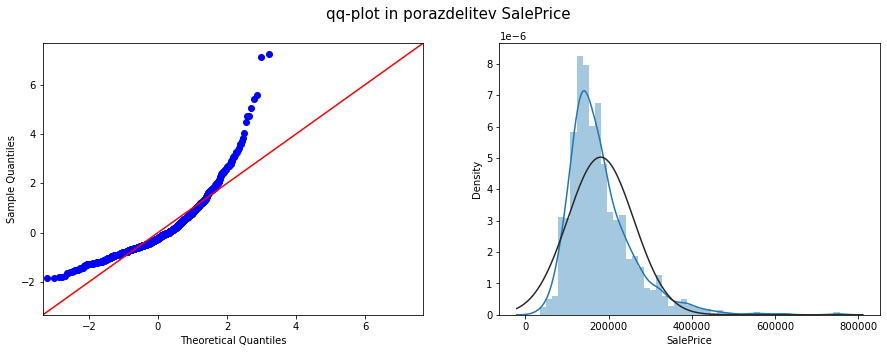

In [7]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

fig.suptitle("qq-plot in porazdelitev SalePrice", fontsize= 15)

sm.qqplot(train["SalePrice"],
          stats.t,
          distargs=(4,),
          fit=True,
          line="45",
          ax=ax[0])

sns.distplot(train["SalePrice"],
             kde=True,
             hist=True,
             fit=norm,
             ax=ax[1])

plt.show()

Pri predmetu linearni modeli smo se naučili, da je takšne spremenljivke dobro transformirati. Poskusimo z logaritmom (zamaknemo še vse vrednosti za 1, da se izognemo morebitnim neskončnim vrednostim)

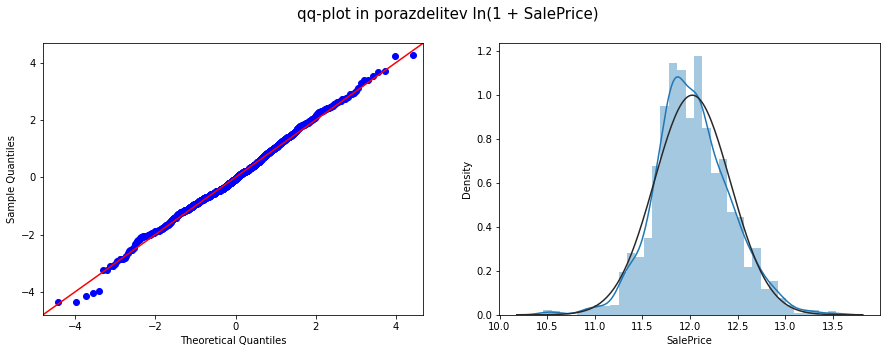

In [8]:
SalePrice_log = np.log1p(train["SalePrice"])

fig, ax = plt.subplots(1,2, figsize= (15,5))

fig.suptitle("qq-plot in porazdelitev ln(1 + SalePrice)", fontsize= 15)

sm.qqplot(SalePrice_log,
          stats.t,
          distargs=(4,),
          fit=True,
          line="45",
          ax=ax[0])

sns.distplot(SalePrice_log,
             kde=True,
             hist=True,
             fit=norm,
             ax=ax[1])

plt.show()

Vidimo zelo dobro izboljšavo. Nadaljujemo s tem. Preden se začnemo ukvarjati z ostalimi spremenljivkami, preverimo kako izgledajo manjkajoče vrednosti.

In [9]:
total_train = train.isnull().sum().sort_values(ascending=False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total_train, percent_train], axis=1, keys=["Total", "Percent"])

total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test
                .isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=["Total", "Percent"])

display_side_by_side([missing_data_train.head(35), missing_data_test.head(35)], ["train", "test"])

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


Vidimo da nam prvih $5$ spremenljivk predstavlja težavo saj imajo od približno $50\%$ naprej manjkajočih vrednosti. Poleg tega vidimo da je v `test` vzorcu pri več spremenljivkah manjkajočih vrednosti.

Dajmo najprej popraviti oz. poskrbeti glede manjkajočih vrednosti. Večino manjkajočih vrednosti sem popravil tako kot je zapisano v navodilih, bodisi da sem ustvaril novo kategorijo, saj NA nekaj pomeni, oz. nadomestil z 0 ker ni imela ene izmed spremenljivk ali nadomestil z najbolj pogosto spremenljivko v primerih ko je bilo manjkajočih zelo malo ipd.

In [10]:
# ni potrebe da je številska

str_vars = ["MSSubClass", "YrSold", "MoSold"]

for var in str_vars:
    train[var] = train[var].apply(str)
    test[var] = test[var].apply(str)

In [11]:
# zamenjamo z najbolj pogosto

common_vars = ["Exterior1st",
               "Exterior2nd",
               "SaleType",
               "Electrical",
               "KitchenQual"]

for var in common_vars:
    train[var] = train[var].fillna(train[var].mode()[0])
    test[var] = test[var].fillna(train[var].mode()[0])
    

In [12]:
# izračunamo najbolj pogosto vrednost za MSZoning glede na MSSubClass (če jih je več, uporabimo prvo)

msz_mss_mod_dict = train.groupby(["MSSubClass"])["MSZoning"].agg(
    lambda x: pd.Series.mode(x)[0]).to_dict()

train["MSZoning"] = train["MSZoning"].fillna(train["MSSubClass"].map(msz_mss_mod_dict))
test["MSZoning"] = test["MSZoning"].fillna(train["MSSubClass"].map(msz_mss_mod_dict))


In [13]:
# zamenjamo missing z "None", saj kot piše v datoteki NA pomeni da nimajo te stvari

none_col = ["GarageType",
            "GarageFinish",
            "GarageQual",
            "GarageCond",
            "GarageYrBlt",
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
            "BsmtFinType2",
            "PoolQC",
            "Alley",
            "Fence",
            "MiscFeature",
            "FireplaceQu",
            "MasVnrType",
            "Utilities"]

for col in none_col:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

In [14]:
# LotFrontage NA glede na Neighborhood mediano

lot_nbr_med_dict = train[["LotFrontage", "Neighborhood"]].dropna().groupby("Neighborhood").median().to_dict()
train["LotFrontage"] = train["LotFrontage"].fillna(train["Neighborhood"].map(lot_nbr_med_dict["LotFrontage"]))
test["LotFrontage"] = test["LotFrontage"].fillna(test["Neighborhood"].map(lot_nbr_med_dict["LotFrontage"]))

In [15]:
# sem pozabil prej spremeniti

train["GarageYrBlt"] = train["GarageYrBlt"].apply(str)
test["GarageYrBlt"] = test["GarageYrBlt"].apply(str)


# zamenjajmo z 0, saj če je NA pomeni da nimajo tega.
zero_col = ["GarageYrBlt",
            "GarageArea",
            "GarageCars",
            "MasVnrArea",
            "BsmtFinSF1",
            "BsmtFinSF2",
            "BsmtFullBath",
            "BsmtHalfBath",
            "FullBath",
            "HalfBath",
            "BsmtUnfSF",
            "TotalBsmtSF"]

for col in zero_col:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)


# data opis -> Functional: Home functionality (Assume typical unless deductions are warranted)
train['Functional'] = train['Functional'].fillna("Typ")
test['Functional'] = test['Functional'].fillna("Typ")

In [16]:
total_train = train.isnull().sum().sort_values(ascending=False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total_train, percent_train], axis=1, keys=["Total", "Percent"])

total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test
                .isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=["Total", "Percent"])

display_side_by_side([missing_data_train.head(), missing_data_test.head()], ["train", "test"])

,Total,Percent
MSSubClass,0,0.000000
MSZoning,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000
,Total,Percent
MSSubClass,0,0.000000
BedroomAbvGr,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


Ostali smo brez manjkajočih vrednosti, kar je odlično.


## Ustvarjanje novih spremenljivk

Glede na to kaj je bilo bistvo prejšnje naloge, ter kar smo se kasneje pogovarjali tudi pri nadaljnjih predavanjih je smiselno pogledati če lahko ustvarimo nove spremenljivke.

Prve smiselne so, da seštejemo nekatere vrednosti, ki so razdeljene po nadstropjih/prostorih/itd in da preračunamo nekaj novih.

In [17]:
train["YrBltAndRemod"]=train["YearBuilt"]+train["YearRemodAdd"]
test["YrBltAndRemod"]=test["YearBuilt"]+test["YearRemodAdd"]

train["YrBltAndRemod"] = train["YrBltAndRemod"].apply(str)
test["YrBltAndRemod"] = test["YrBltAndRemod"].apply(str)


train["TotalSF"]=(train["TotalBsmtSF"] +
                 train["1stFlrSF"] +
                 train["2ndFlrSF"])
        
test["TotalSF"]=(test["TotalBsmtSF"] +
                test["1stFlrSF"] + 
                test["2ndFlrSF"])


train["Total_sqr_footage"] = (train["BsmtFinSF1"] +
                              train["BsmtFinSF2"] +
                              train["1stFlrSF"] +
                              train["2ndFlrSF"])

test["Total_sqr_footage"] = (test["BsmtFinSF1"] +
                             test["BsmtFinSF2"] +
                             test["1stFlrSF"] +
                             test["2ndFlrSF"])

# 0.5 ker so polovične
train["Total_Bathrooms"] = (train["FullBath"] +
                            (0.5 * train["HalfBath"]) +
                            train["BsmtFullBath"] +
                            (0.5 * train["BsmtHalfBath"]))

test["Total_Bathrooms"] = (test["FullBath"] +
                           (0.5 * test["HalfBath"]) +
                           test["BsmtFullBath"] + 
                           (0.5 * test["BsmtHalfBath"]))

train["Total_porch_sf"] = (train["OpenPorchSF"] +
                           train["3SsnPorch"] +
                           train["EnclosedPorch"] +
                           train["ScreenPorch"] +
                           train["WoodDeckSF"])

test["Total_porch_sf"] = (test["OpenPorchSF"] +
                          test["3SsnPorch"] +
                          test["EnclosedPorch"] +
                          test["ScreenPorch"] +
                          test["WoodDeckSF"])

train['haspool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['has2ndfloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasgarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['hasbsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['hasfireplace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

test['haspool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['has2ndfloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['hasgarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['hasbsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['hasfireplace'] = test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

train["SqFtPerRoom"] = train["GrLivArea"] / (train["TotRmsAbvGrd"] +
                                             train["FullBath"] +
                                             train["HalfBath"] +
                                             train["KitchenAbvGr"])

test["SqFtPerRoom"] = test["GrLivArea"] / (test["TotRmsAbvGrd"] +
                                           test["FullBath"] +
                                           test["HalfBath"] +
                                           test["KitchenAbvGr"])

train['Total_Home_Quality'] = (train['OverallQual'] + 
                              train['OverallCond'])

test['Total_Home_Quality'] = (test['OverallQual'] + 
                             test['OverallCond'])
    
train["HighQualSF"] = (train["1stFlrSF"] + 
                      train["2ndFlrSF"])
    
test["HighQualSF"] = (test["1stFlrSF"] + 
                     test["2ndFlrSF"])

Poglejmo si sedaj razsevne grafikone kjer je odvisna spremenljivka naša napovedna spremenljivka `SalePrice`

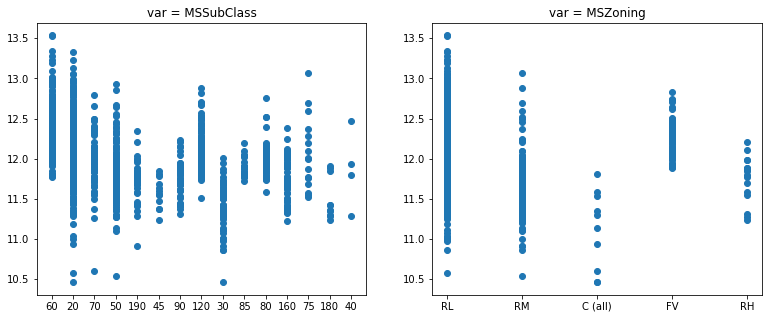

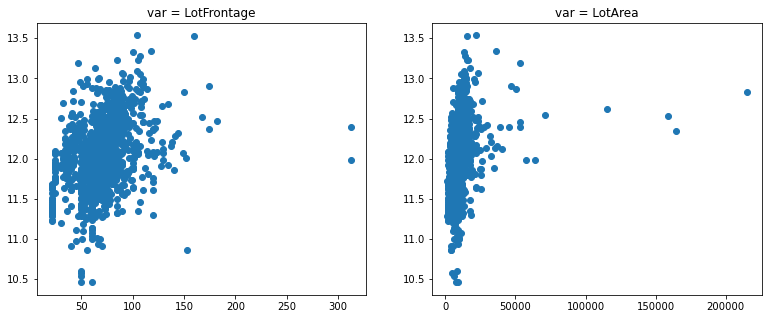

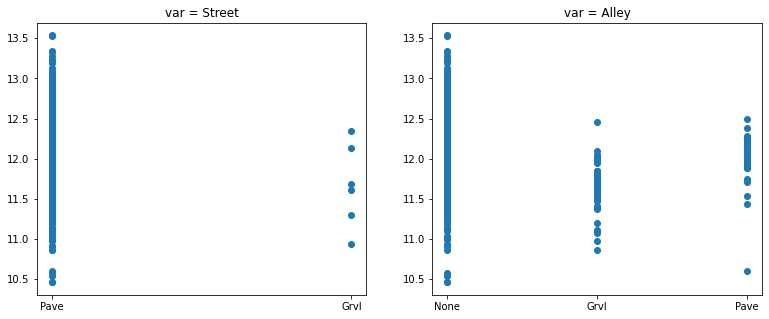

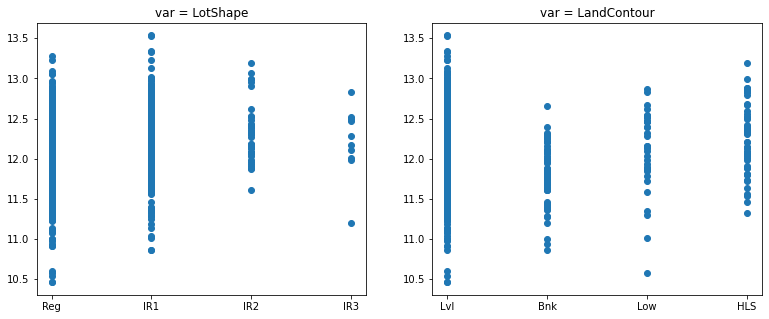

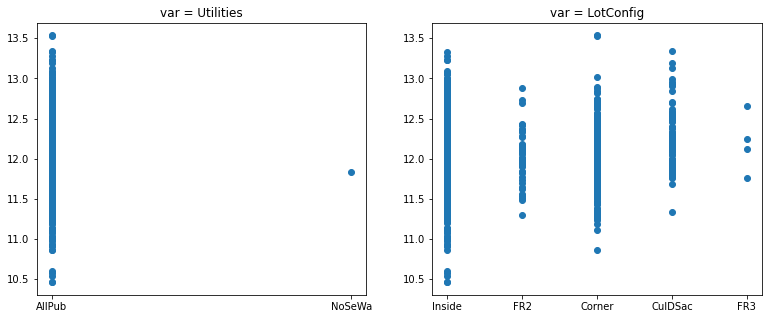

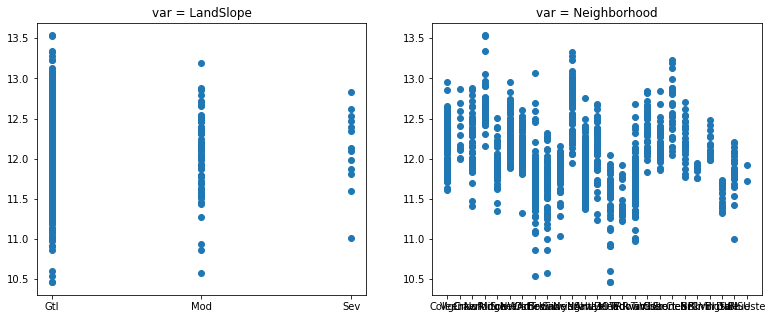

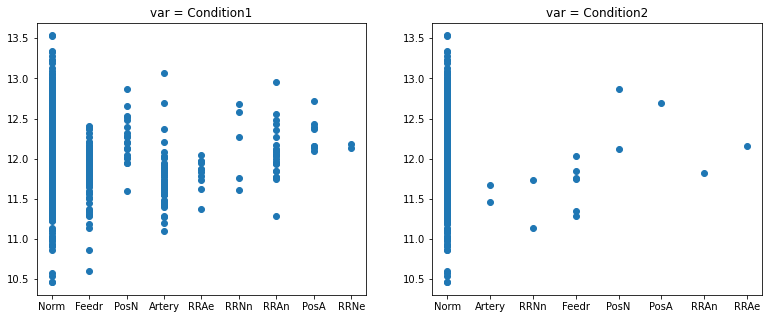

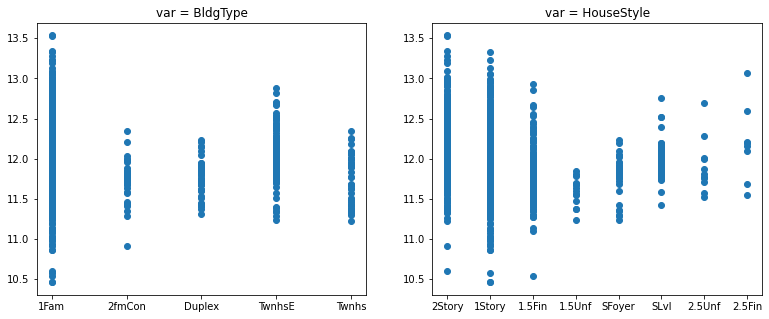

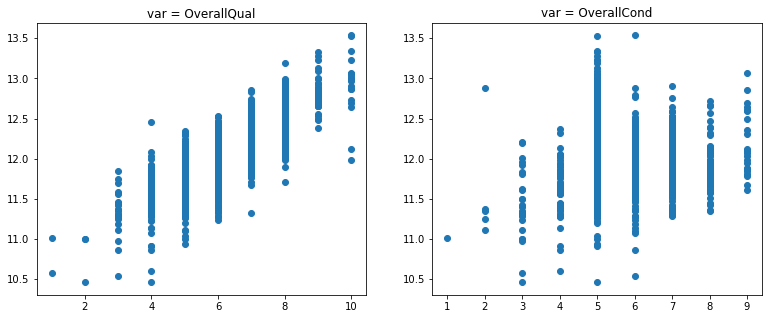

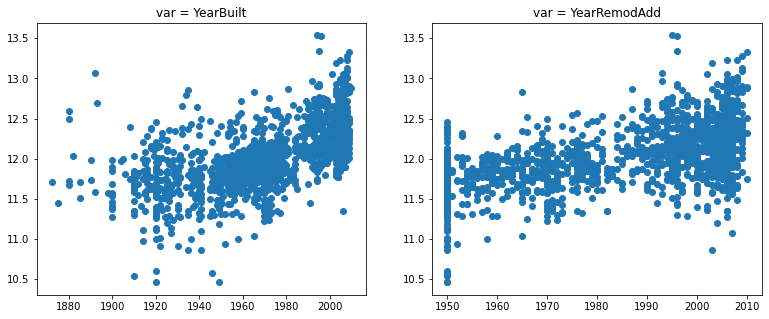

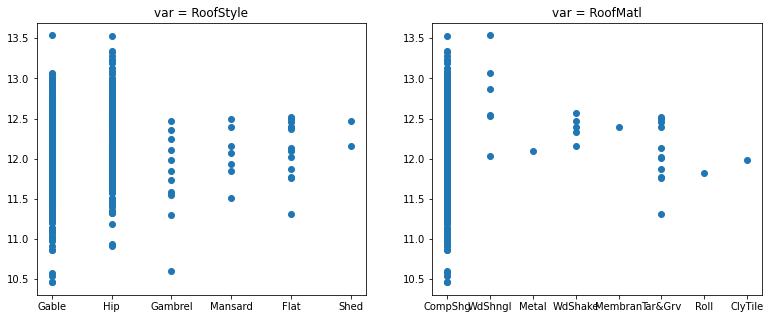

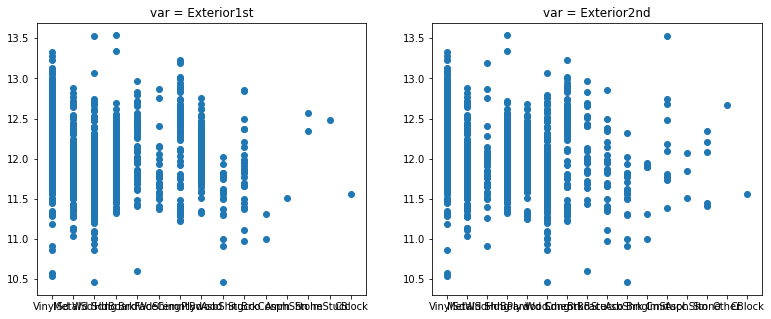

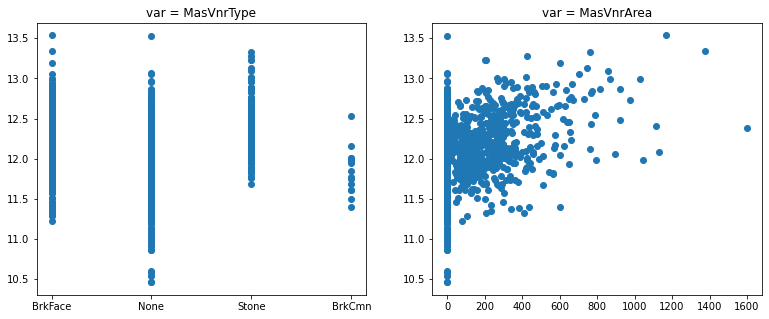

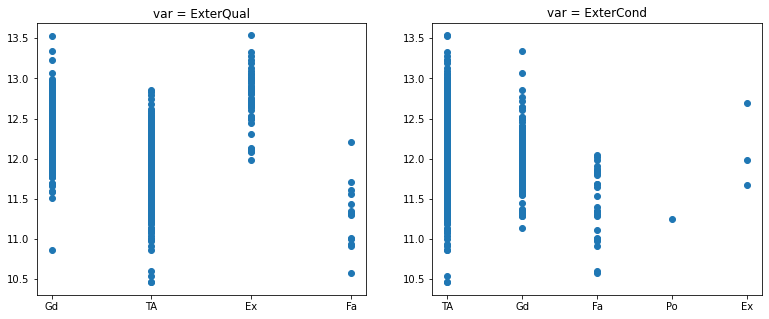

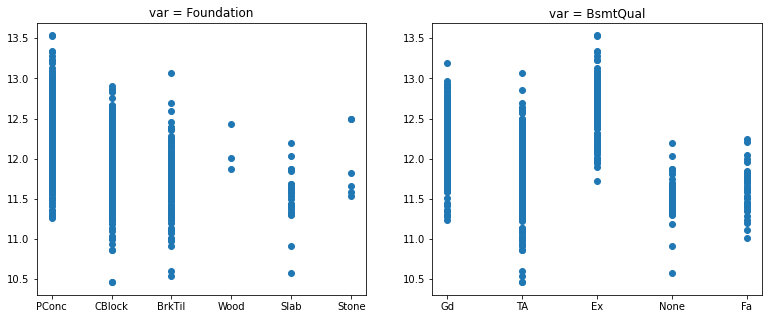

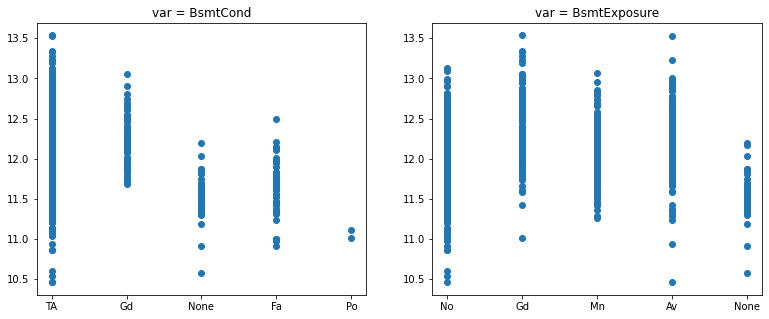

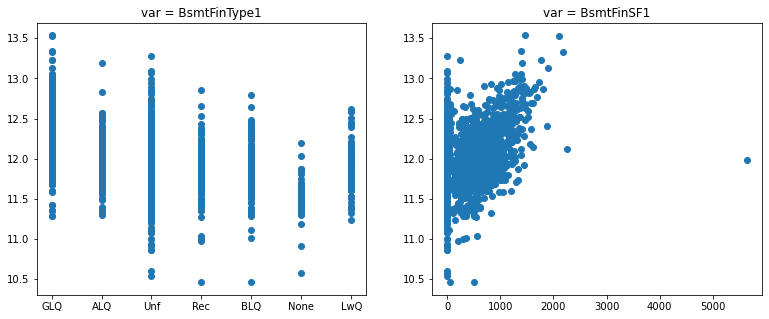

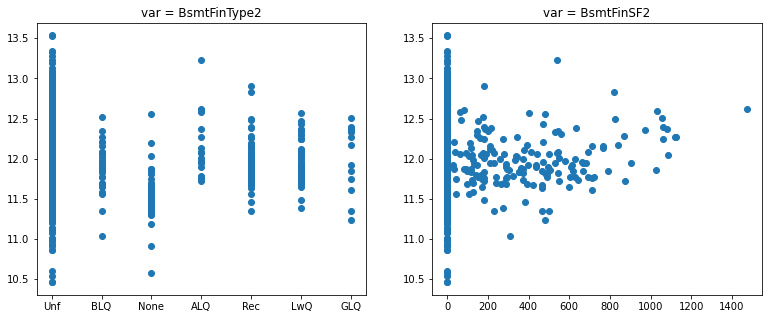

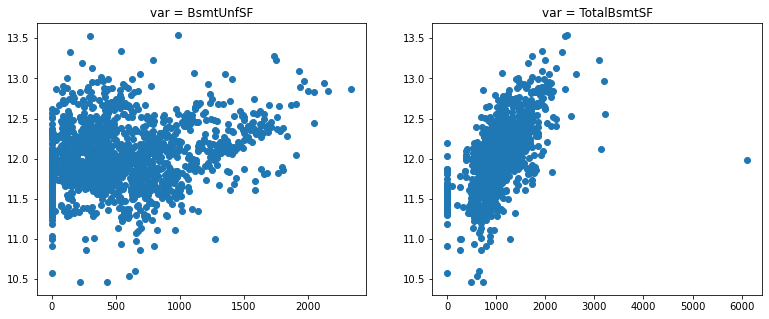

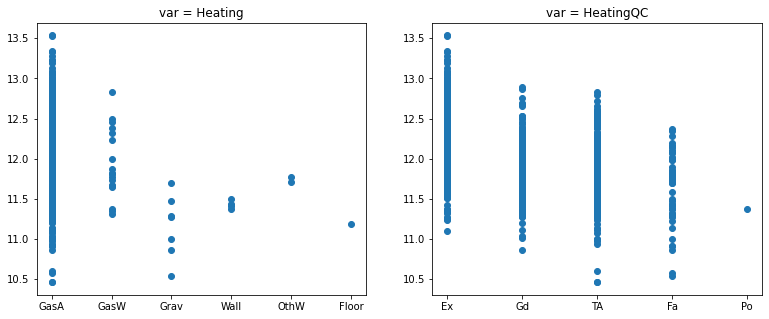

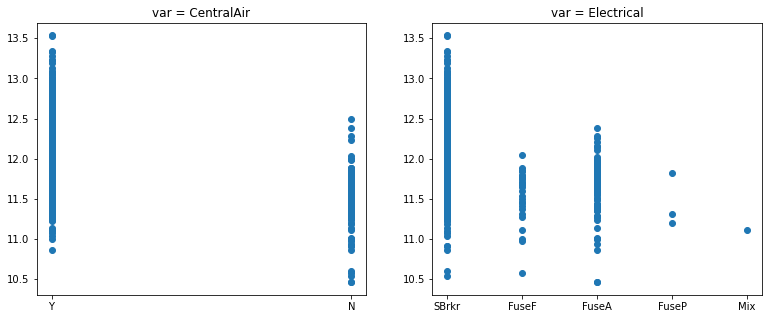

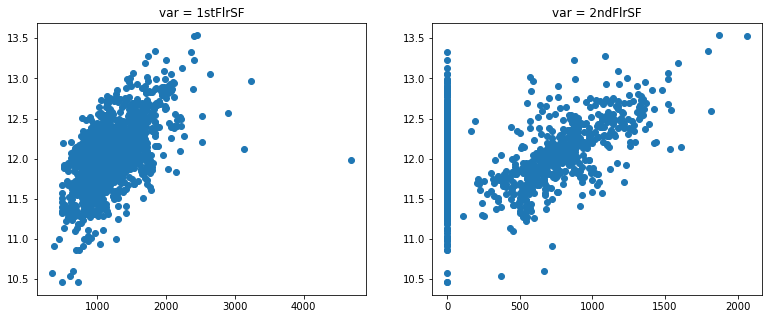

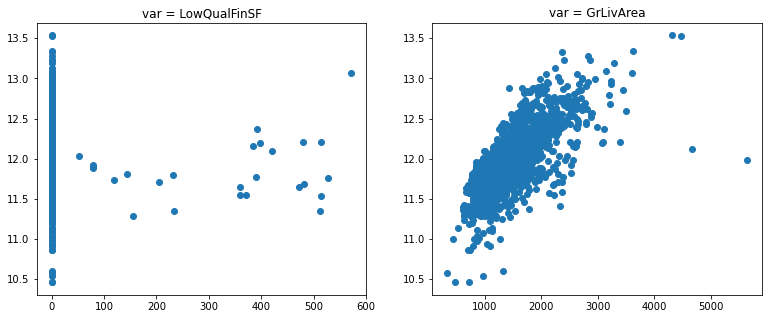

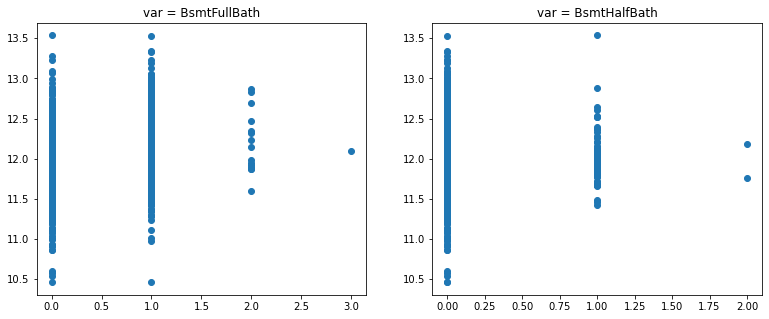

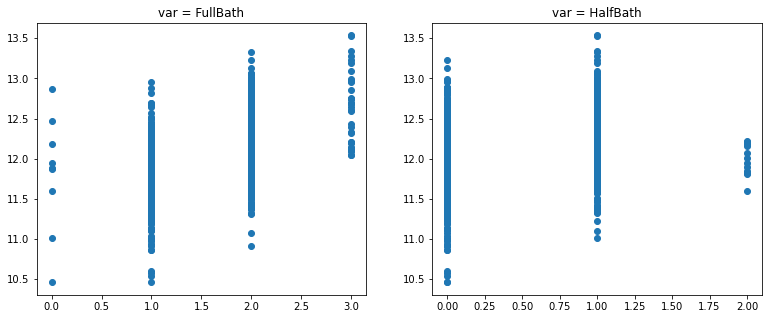

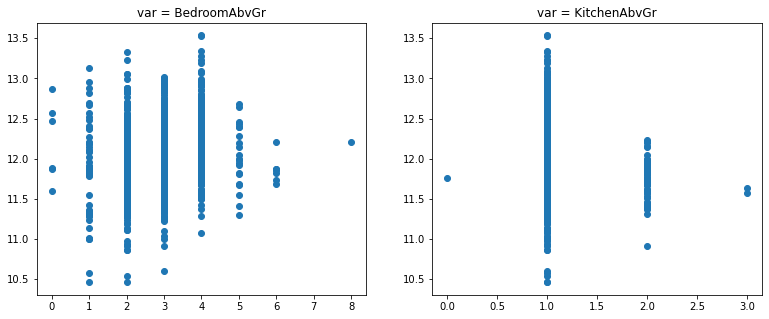

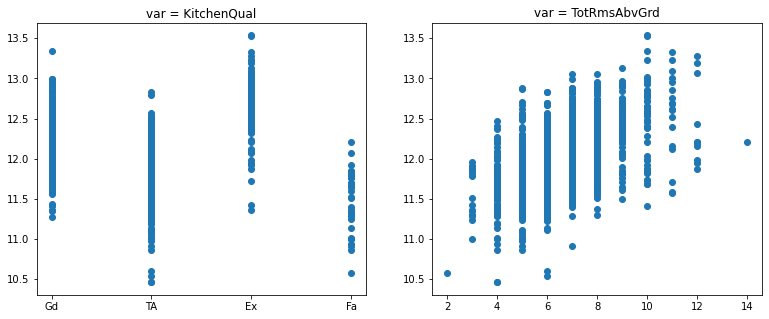

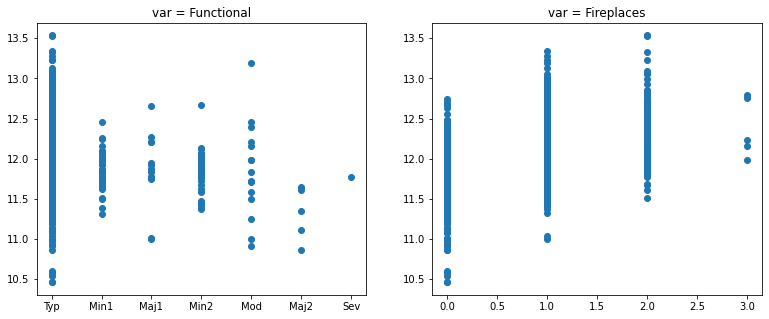

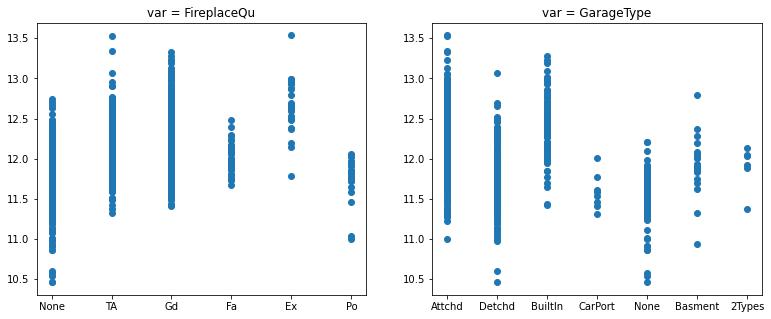

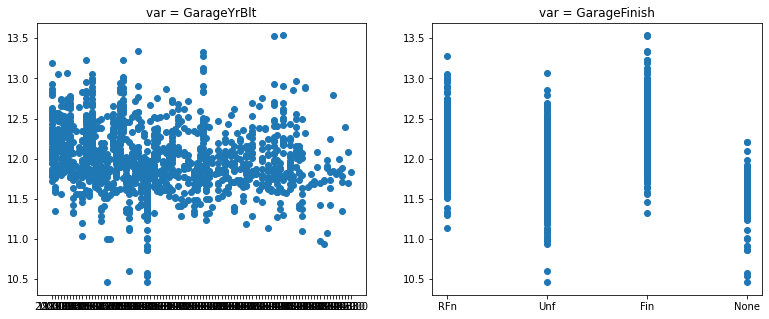

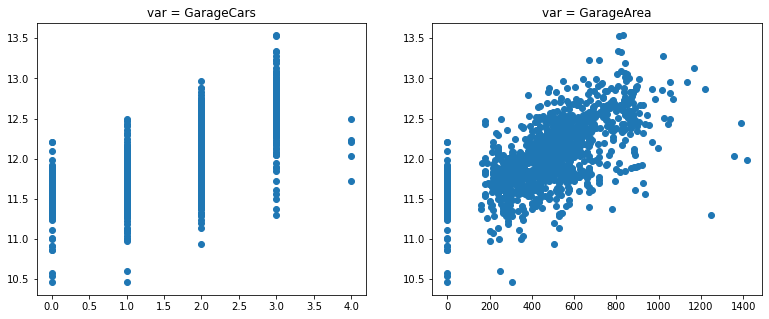

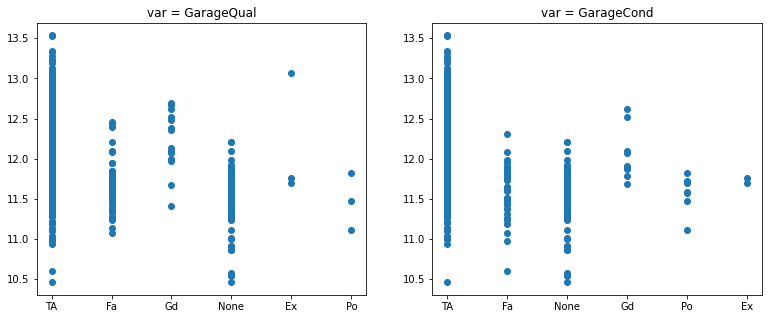

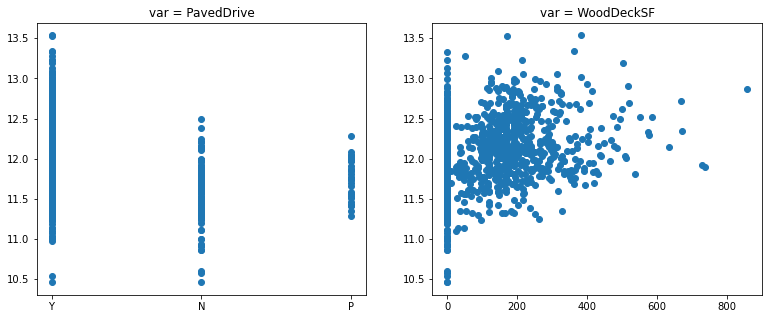

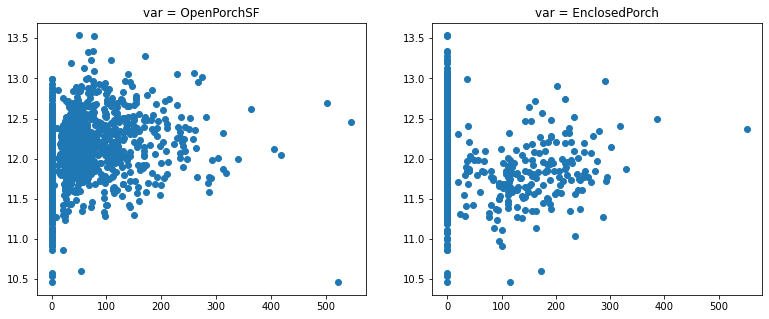

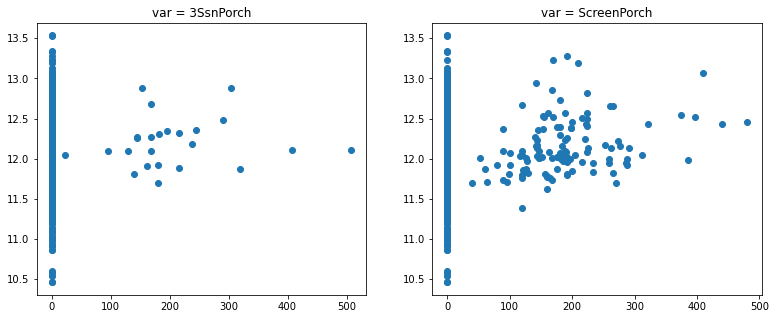

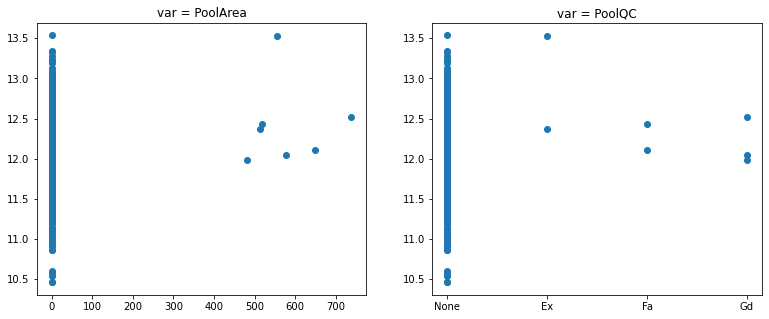

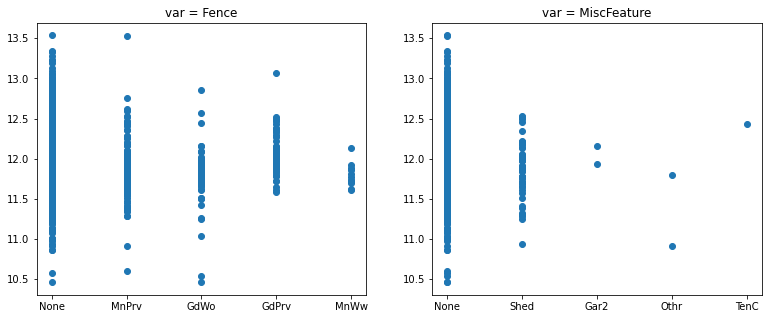

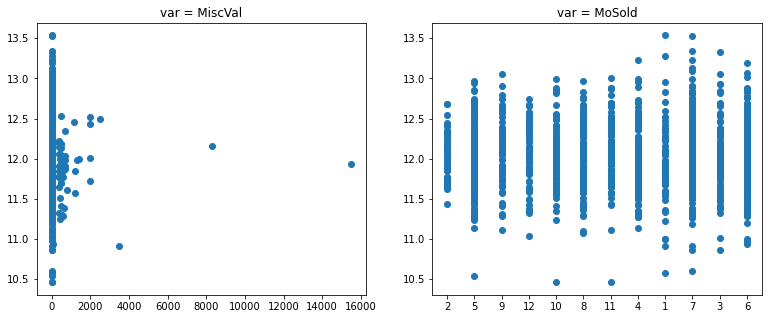

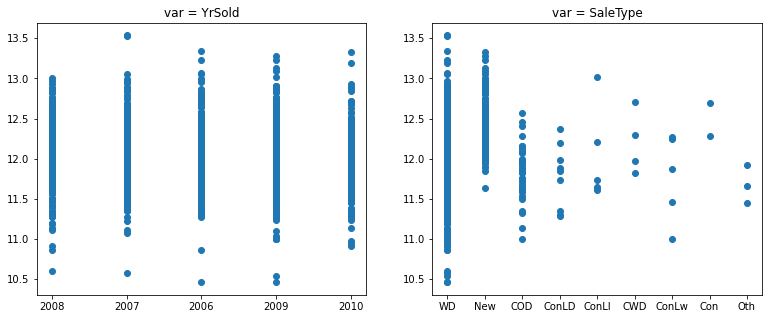

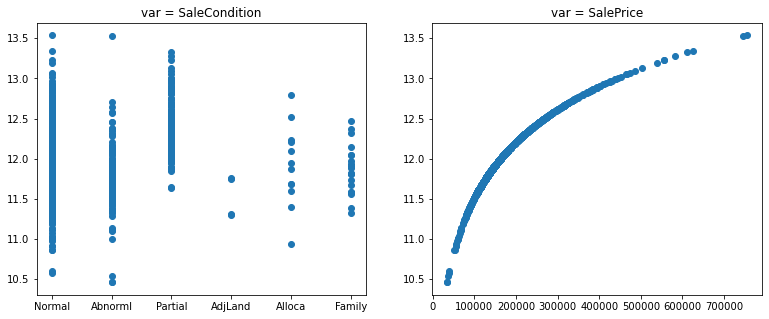

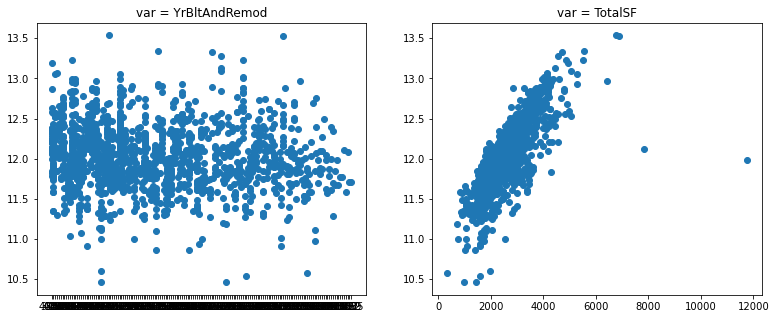

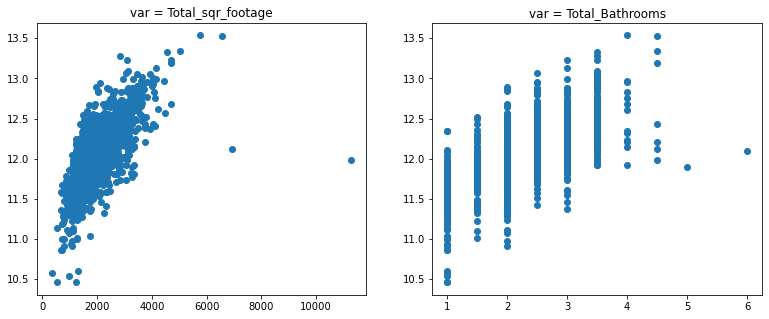

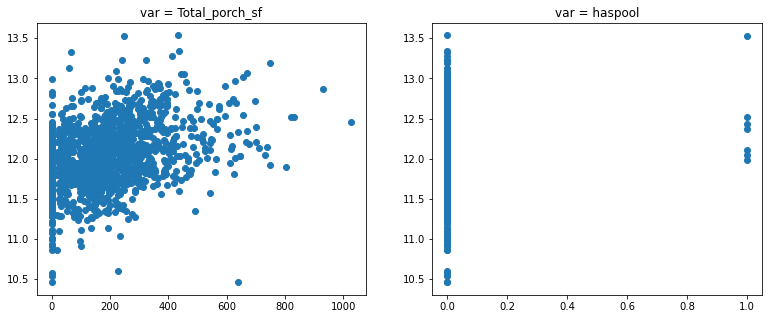

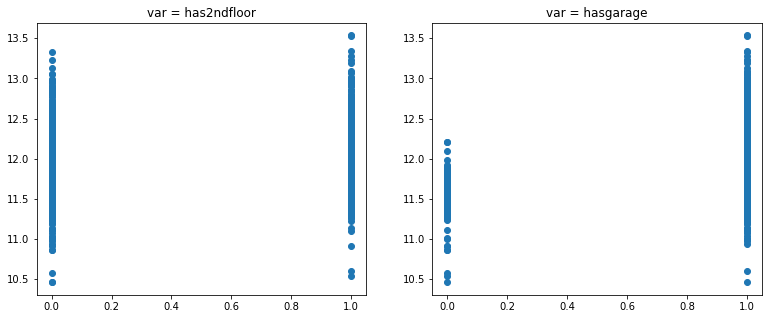

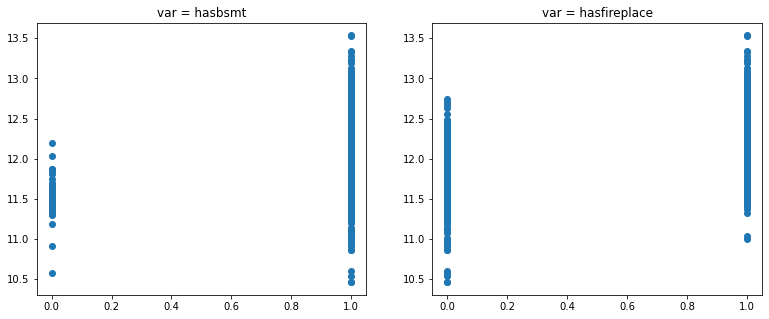

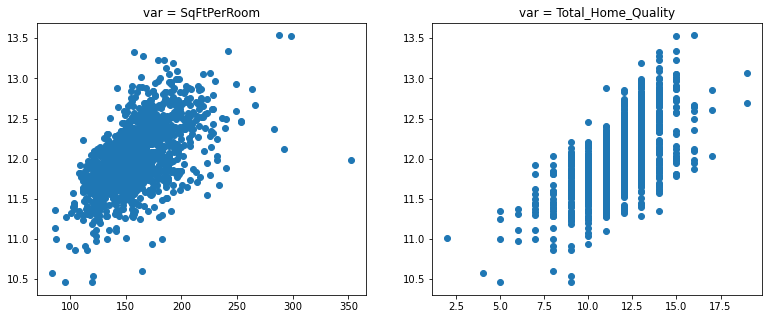

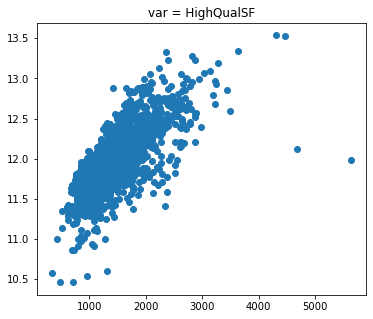

In [18]:
vars = train.columns
figures_per_row = 2
count = 0 
y = SalePrice_log
for var in vars:
    x = train[var]
    plt.figure(count//figures_per_row,
               figsize=(13,5))
    plt.subplot(1,
                figures_per_row,
                np.mod(count,2)+1)
    plt.scatter(x, y);
    plt.title("var = {}".format(var))
    count+=1

Opazimo nekaj zelo lepih odvisnosti (tudi na novo dodanih spremenljivk), kot je npr. `TotalSF`. Mogoče bi prav prišla še kaka transformacija nekaterim spremenljivkam, vendar se temu posvetim drugič. Je pa opaziti da so nekatere spremenljivke, kljub temu da smo obdelali manjkajoče vrednosti, precej neprimerne. Namreč imajo premalo različnih vrednosti oz. preveč 1 vrednosti. Trenutno ne nameravam odstraniti nobene izmed spremenljivk. Poglejmo si še korelacije številskih spremenljivk, ker so nekatere zagotovo zelo korelirane.

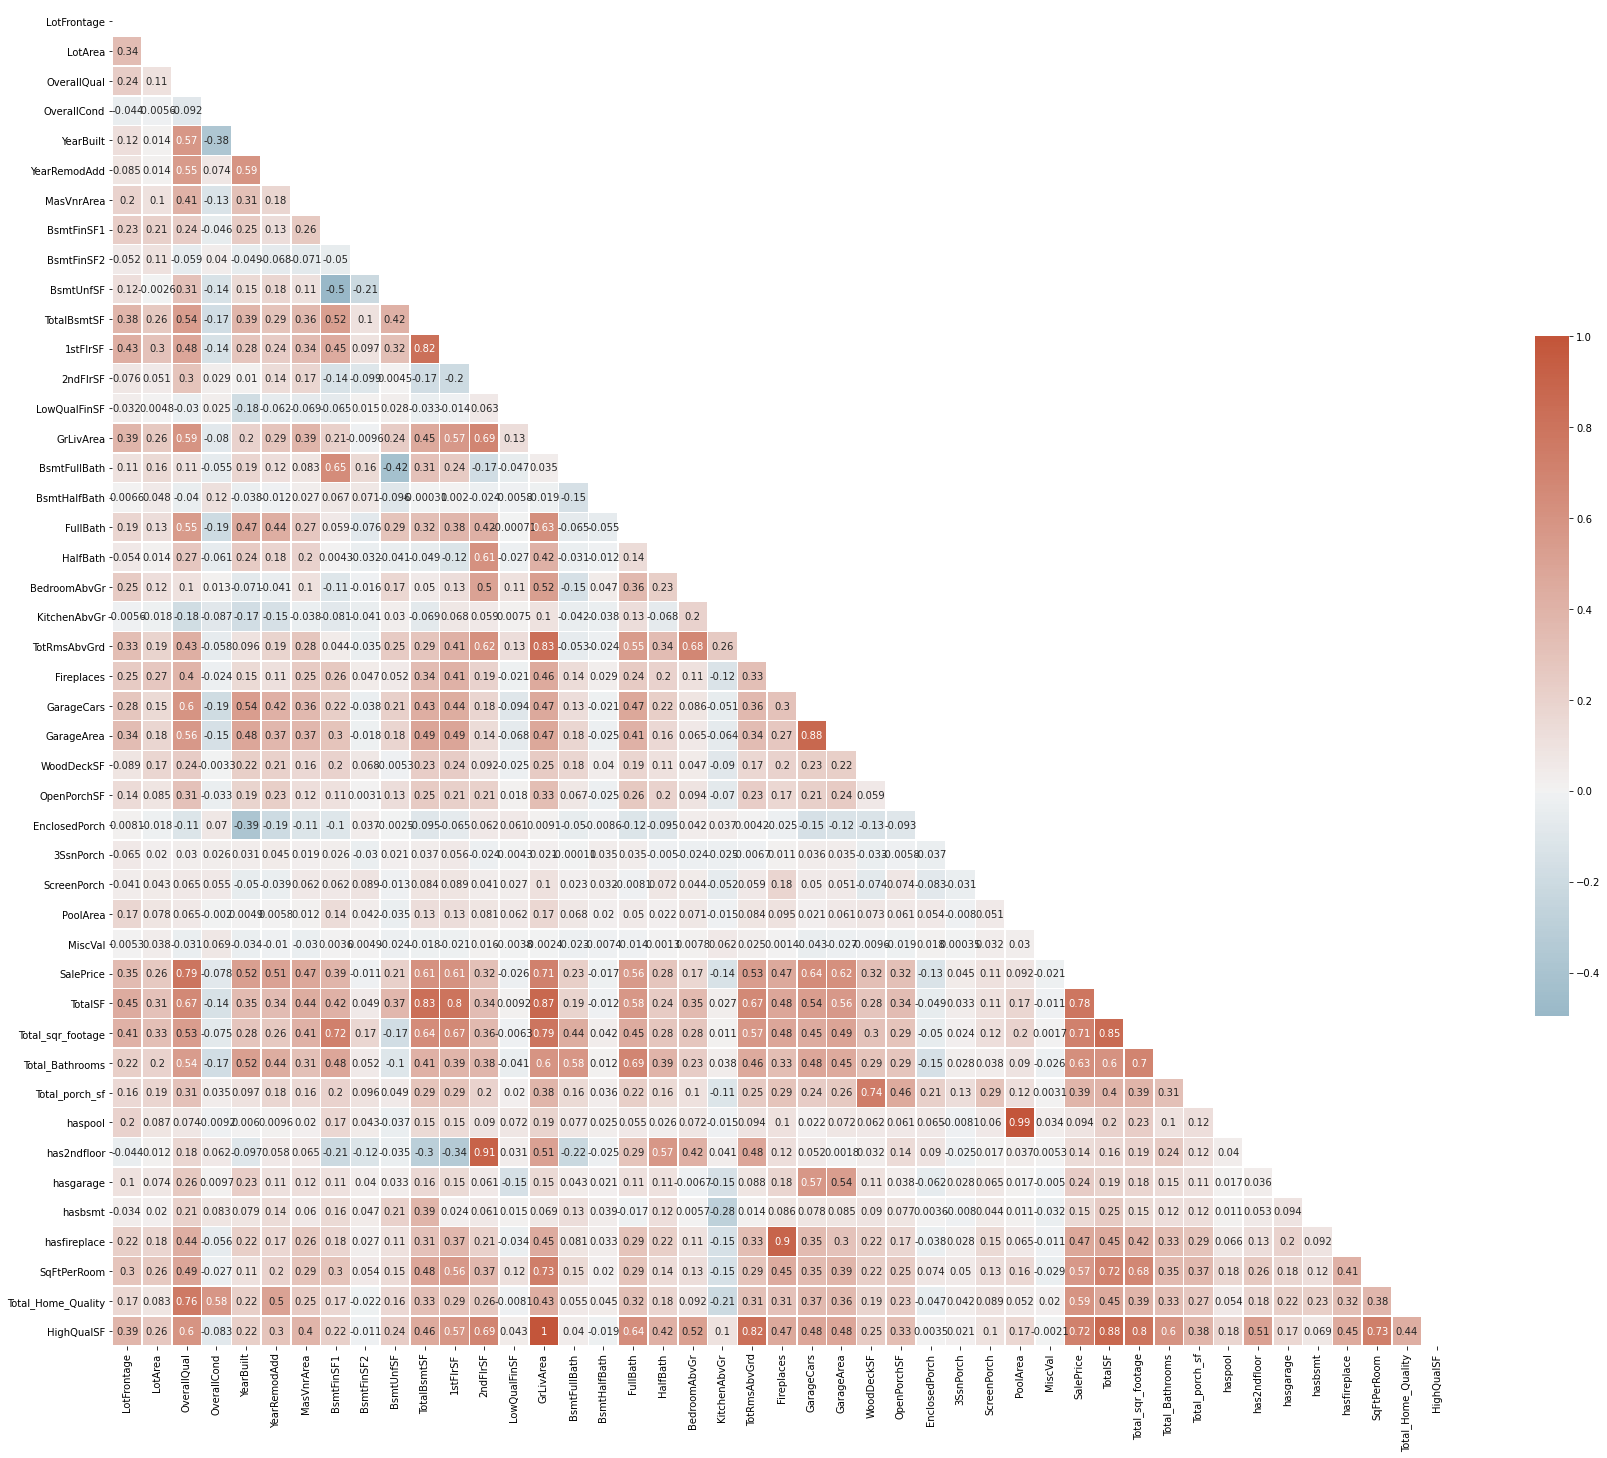

In [19]:
f, ax = plt.subplots(figsize=(30, 25))
mat = train.corr("pearson")
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0, 
            annot = True,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.show()

Vidimo da je `SalePrice` visoko koreliran z `OverallQual`, `TotalSF`, `HighQualSF`, `GrLivArea` in `Total_sqr_footage` (nad $0.7$). Pričakujem da bodo nekatere izmed teh spremenljivk najbolj vplivne na ceno.

In [20]:
# one hot encoding za kategorične spremenljivke

full_data = pd.get_dummies(pd.concat([train, test], axis=0).reset_index(drop=True))

train=full_data.iloc[:len(train), :]
test=full_data.iloc[len(train):, :]

train=train.drop("SalePrice", axis="columns")

## Modeli

Uvozimo ostale pakete s katerimi bomo modelirali

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

Poglejmo si kateri model bi bil najboljši. Primerjamo `ridge`, `lasso`, `ElasticNET`, `SVR` (SVM regresija), `lightgbm` in `xgboost`.

In [22]:
kfolds = KFold(n_splits=18, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, SalePrice_log, scoring="neg_mean_squared_error", cv=kfolds))
    return(rmse)

# rmse scoring function
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Ridge Regresija
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))

# LASSO Regresija
lasso = make_pipeline(RobustScaler(), LassoCV(cv=kfolds))

# elastični Net Regresija 
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(cv=kfolds))

# podporni vektor mašina
svr = make_pipeline(RobustScaler(), SVR())


lightgbm = LGBMRegressor(objective="regression",
                         learning_rate=0.01, 
                         n_estimators=3500)

# naključno izbran n_estimators in learning_rate
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3500,
                       objective="reg:squarederror",
                       seed=8)

models = {"Ridge": ridge,
          "Lasso": lasso, 
          "ElasticNet": elasticnet,
          "lightgbm": lightgbm,
          "Svr": svr,
          "xgboost": xgboost}

predictions = {}
scores = {}

In [23]:
for name, model in models.items():
    
    model.fit(train, SalePrice_log)
    predictions[name] = np.expm1(model.predict(train)) # inverzna funkcija log1p
    
    score = cv_rmse(model)
    scores[name] = (score.mean(), score.std())

Prikažimo povprečja in standardne odklone v tabeli.

In [24]:
tmp = pd.DataFrame(scores)
tmp.index = ["RMSE mean", "RMSE std"]
tmp

,Ridge,Lasso,ElasticNet,lightgbm,Svr,xgboost
RMSE mean,0.131,0.144,0.144,0.129,0.342,0.123
RMSE std,0.044,0.052,0.051,0.026,0.043,0.025


Vidimo da se najbolje obnese `xgboost`, zelo blizu mu sledi `lightgbm` in ne daleč za njim še `ridge` regresija. Za sestavitev modela se odločim za `xgboost`. Še enkrat fittamo model, tokrat na celotnih podatkih.

In [25]:
final_model = xgboost.fit(train, SalePrice_log)

In [26]:
# ko smo delali get_dummies se je prikradla noter....
test = test.drop("SalePrice", axis=1)

# še inverz od log1p funkcije da dobimo naše vrednosti
final_price = np.expm1(final_model.predict(test))

Pripravimo naš submission za kaggle.

In [27]:
submission = pd.DataFrame({'Id': test.index+1, 'SalePrice': final_price})

# Exporting submission to CSV
submission.to_csv('submission-v1.csv', index=False)

## Zaključek

Na hitro si poglejmo še pomembnost določenih spremenljivk. Kot najpomembnejša spremenljivka se pokaže `OverallQual` (kot smo pričakovali), ki je iz zgornjih grafov videti zelo linearna in zato me to ne preseneča. Precej pomembni sta še `YearBuilt` in `YearRemodAdd` ki pravzaprav upoštevata to kdaj je bila nepremičnina zgrajena/obnovljena, kar je nekako pričakovano. Ostale spremenljivke prispevajo nekaj, vendar v primerjavi z omenjenimi tremi, malo.

In [28]:
pd.DataFrame({"Feature" : train.columns.to_list(), 
              "Importance": xgboost.feature_importances_}).head(15).sort_values(by='Importance', ascending=False)

,Feature,Importance
2,OverallQual,0.024
4,YearBuilt,0.013
5,YearRemodAdd,0.008
3,OverallCond,0.003
1,LotArea,0.001
11,1stFlrSF,0.001
12,2ndFlrSF,0.001
14,GrLivArea,0.001
8,BsmtFinSF2,0.001
7,BsmtFinSF1,0.001


Končni rezultat, po objavi na kaggleu je bil enak $0.13060$ (RMSLE), kar je nekoliko slabše glede na prečno preverjanje, kar nakazuje na preprileganje. Je pa še vedno nekoliko v območju ostalih metod, tako da najverjetneje preprileganje ni preveliko.

Nekoliko več časa sem posvetil pravilnemu nadomeščanju manjkajočih vrednosti ter ustvarjanju nekaterih novih spremenljivk. Poskusil sem si "vsebinsko" razložiti kaj bi lahko bilo prediktivno in na ta način ustvaril nekatere spremenljivke.
Prostora za izboljšanje je ogromno. Predvsem bi posvetil nekoliko več časa iskanju pravih parametrov za metode. Žal nisem imel več časa da bi pregledal kaj ostali parametri pravzaprav počnejo. Podobno bi si lahko vzel še nekoliko več časa za ustvarjanje novih spremenljivk.